# Service Qualification Exercise

This script is a  implementation of a possible simple model of grid service qualification procedure of different devices.

First, the picewise-to-transfer function conversion from the paper Verena et al. <https://arxiv.org/pdf/2310.01552> is implemented to yield a reference.

Next, we want the devices to follow the transfer function as a reference. The control block diagram is as follows: (see latex)

toto: find realistic saturation limits, device-level maximum and regulation-minimum curve to assess if pass test

In [37]:
# Import the packages needed for the examples included in this notebook
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

# Import the python-control package
try:
    import control as ct
    print("python-control", ct.__version__)
except ImportError:
    %pip install control
    import control as ct

python-control 0.10.0


(0.0, 50.0)

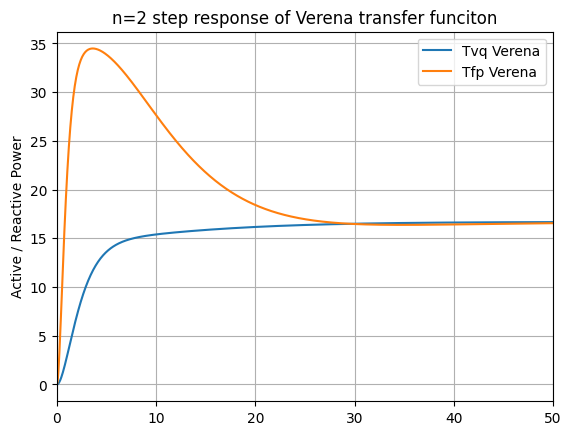

In [38]:
# get transfer function from verena's paper, second order
ss = ct.tf('s')  # create a transfer function variable
Tfcr_verena = 0.2963 / (ss**2 + 0.2667*ss + 0.01778)
# First transfer function T_des,ffr^fp(s, α)
num1 = [143.7, 154.6, 59.75, 7.599, 0]  # numerator coefficients
den1 = [1, 5.17, 9, 6.26, 2.03, 0.3077, 0.0176]  # denominator coefficients
Tffr_verena = ct.TransferFunction(num1, den1)
# Second transfer function T_des^vq(s, α)
num2 = [9.422, 2.56, 0.1897]  # numerator coefficients
den2 = [1, 1.867, 1.084, 0.1991, 0.01137]  # denominator coefficients
Tvq_verena = ct.TransferFunction(num2, den2)
Tfp_verena = Tfcr_verena + Tffr_verena  # FFR + FCR service

# plot verena transfer function
# get step response
tlim = [0, 50]
t = np.linspace(tlim[0], tlim[1], 1000)
t, yvq = ct.step_response(Tvq_verena, T=t)
t, fp = ct.step_response(Tfp_verena, T=t)
plt.plot(t, yvq, label='Tvq Verena')
plt.plot(t, fp, label='Tfp Verena')
plt.legend()
plt.grid()
plt.title('n=2 step response of Verena transfer funciton')
plt.ylabel('Active / Reactive Power')
plt.xlim(tlim)

## define helpers

In [39]:
# s = ct.tf('s')  # create a transfer function variable
s = sp.symbols('s')  # create a symbolic variable for SymPy

def pade(t, n=2):
    # [n/n] Pade for e^{-t s}: ((1 - s t /(2n))^n)/((1 + s t /(2n))^n)
    if t==0: return 1
    return ((1 - s*t/(2*n))**n) / ((1 + s*t/(2*n))**n)

def Y_segment(yi, yj, ti, tj, n=2):
    # Eq. (11): Y_ij(s) = ((yi - yj)/s + d/s^2) * (e^{-ti s} - e^{-tj s})
    d = (yj - yi) / (tj - ti)
    return (yi + d/s) * pade(ti, n) - (yj + d/s) * pade(tj, n)

def sympy_to_tf(T_sym, s=sp.symbols('s')):
    """
    Convert a SymPy rational function T(s) into a python-control TransferFunction.
    """
    num, den = sp.fraction(sp.together(T_sym))   # separate numerator and denominator
    num_poly = sp.Poly(sp.expand(num), s)
    den_poly = sp.Poly(sp.expand(den), s)

    # coefficients in descending powers of s
    num_coeffs = [float(c) for c in num_poly.all_coeffs()]
    den_coeffs = [float(c) for c in den_poly.all_coeffs()]

    return ct.tf(num_coeffs, den_coeffs)

## FCR control reference

In [40]:
ti, ta, Dp = 2, 30, 0.06

In [41]:
def build_fcr_tf(ti, ta, Dp, n=2, t_final=50,
                 cutoff_mag=[],
                 rm_zeros=False,
                 gain=1) -> ct.TransferFunction:
    t1, t2, t3 = ti, ta, t_final
    y1, y2, y3 = 0, 1.0 / Dp, 1.0 / Dp
    ts = [t1, t2, t3]
    ys = [y1, y2, y3]

    # Build Y(s) with formula 11
    Y = Y_segment(ys[0], ys[1], ts[0], ts[1], n=n)  # first segment
    # Y += Y_segment(ys[1], ys[2], ts[1], ts[2], n=n)  # second segment
    # for i in range(len(ts) - 1):
    #     yi, yj, ti, tj = ys[i], ys[i + 1], ts[i], ts[i + 1]
    #     d = (yj - yi) / (tj - ti)
    #     Y += yi * pade(ti, n) - yj * pade(tj, n) + d/s * (pade(ti, n) - pade(tj, n))
    
    T = sympy_to_tf(sp.simplify(Y))

    # now cut off the poles and zeros that are too low or high in magnitude
    if cutoff_mag!=[]:
        poles = T.poles()
        zeros = T.zeros()
        # Cut off poles
        poles = [p for p in poles if np.abs(p) > cutoff_mag[0] and np.abs(p) < cutoff_mag[1]]
        if rm_zeros:
            zeros = []
        # build new transfer function
        return ct.zpk(zeros, poles, gain)

    return T

In [42]:
Tfcr_des = build_fcr_tf(ti, ta, Dp, n=2, cutoff_mag=[0.08, 1], rm_zeros=True,
                        gain=0.2963)

(0.0, 50.0)

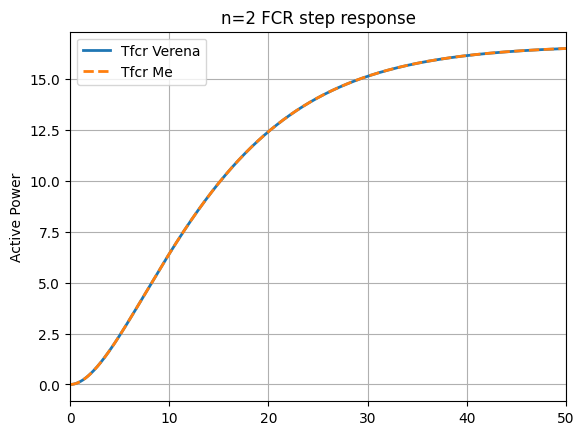

In [43]:
t, yfcr_verena = ct.step_response(Tfcr_verena, T=t)
t, yfcr_des = ct.step_response(Tfcr_des, T=t)
plt.plot(t, yfcr_verena, label='Tfcr Verena', linestyle='-', linewidth=2)
plt.plot(t, yfcr_des, label='Tfcr Me', linestyle='--', linewidth=2)
plt.legend()
plt.grid()
plt.title('n=2 FCR step response')
plt.ylabel('Active Power')
plt.xlim(tlim)

## Voltage Control reference

In [44]:
tvq90, tvq100, Dq = 5, 60, 0.06

In [45]:
import sympy as sp

def build_vq_tf(tvq90, tvq100, Dq, n=2, t_final=1e3,
                cutoff_mag=[],
                 gain=1) -> ct.TransferFunction:
    """
    Construct T_des^vq(s) using the paper's method:
      1) build the unit-step output Y(s) from two linear segments,
      2) then T(s) = s * Y(s),
      3) voltage-control levels: 0 -> 0.9/Dq at tvq90 -> 1/Dq at tvq100.
    n: order of Pade approximation for e^{-t s}.
    Returns a ct.TransferFunction.
    """
    # voltage-control target levels are normalized by Dq
    y1 = 0
    y2 = 0.9 / Dq
    y3, y4 = 1.0 / Dq, 1.0 / Dq
    t1, t2, t3, t4 = 0.0, tvq90, tvq100, t_final
    
    # Build Y(s) from segments
    Y = Y_segment(y1, y2, t1, t2) + Y_segment(y2, y3, t2, t3) + Y_segment(y3, y4, t3, t4)
    T = sympy_to_tf(sp.simplify(Y))

    # quick sanity check: final value of step response must be 1/Dq
    # lim_{s->0} T(s) = 1/Dq
    # assert sp.N(sp.limit(T, s, 0)) == sp.N(1/Dq)
    # now cut off the poles and zeros that are too low or high in magnitude
    if cutoff_mag!=[]:
        poles = T.poles()
        zeros = T.zeros()
        # Cut off poles
        poles = [p for p in poles if np.abs(p) > cutoff_mag[0] and np.abs(p) < cutoff_mag[1]]
        zeros = [z for z in zeros if np.abs(z) > cutoff_mag[0] and np.abs(z) < cutoff_mag[1]]
        # build new transfer function
        return ct.zpk(zeros, poles, gain)

    return T

In [46]:
Tvq_des = build_vq_tf(tvq90, tvq100, Dq, n=2, cutoff_mag = [.1, 1], gain=9)

In [47]:
# compare zeros
cutoff_mag = [.1, 1]
print(Tvq_verena.zeros())
print(Tvq_des.zeros())
print([z for z in Tvq_des.zeros() if np.abs(z) > cutoff_mag[0] and np.abs(z) < cutoff_mag[1]])

[-0.13585226+0.04096209j -0.13585226-0.04096209j]
[-0.1017339+0.03749778j -0.1017339-0.03749778j]
[(-0.10173389538889951+0.037497775976482565j), (-0.10173389538889951-0.037497775976482565j)]


In [48]:
# compare poles
print(Tvq_verena.poles())
print(Tvq_des.poles())
print([p for p in Tvq_des.poles() if np.abs(p) > cutoff_mag[0] and np.abs(p) < cutoff_mag[1]])

[-0.83194602+0.j -0.76800333+0.j -0.13934249+0.j -0.12770816+0.j]
[-0.79999999+0.j -0.80000001+0.j]
[(-0.7999999904586+0j), (-0.8000000095413974+0j)]


(0.0, 50.0)

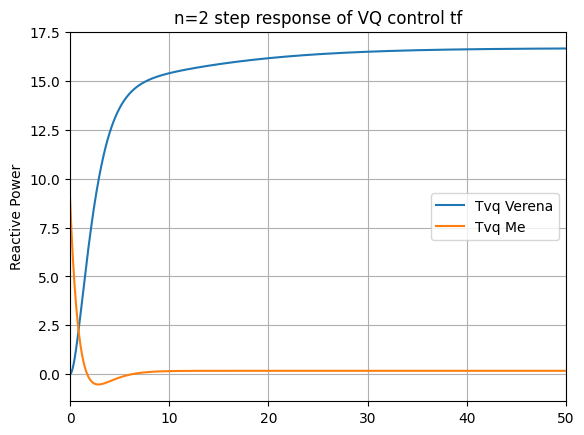

In [49]:
# compare with verena
t, yvq_des = ct.step_response(Tvq_des, T=t)
plt.plot(t, yvq, label='Tvq Verena')
plt.plot(t, yvq_des, label='Tvq Me')
plt.legend()
plt.grid()
plt.title('n=2 step response of VQ control tf')
plt.ylabel('Reactive Power')
plt.xlim(tlim)

## FFR reference

In [50]:
num_ffr = [143.7, 154.6, 59.75, 7.599, 0]
den_ffr = [1, 5.17, 9, 6.26, 2.03, 0.3077, 0.0176]

Tffr_des = ct.TransferFunction(num_ffr, den_ffr)

_, yffr_des = ct.step_response(Tffr_des, T=t)

yffr_fcr_des = np.add(yfcr_des, yffr_des)

In [51]:
out = yfcr_des + yffr_des

(0.0, 50.0)

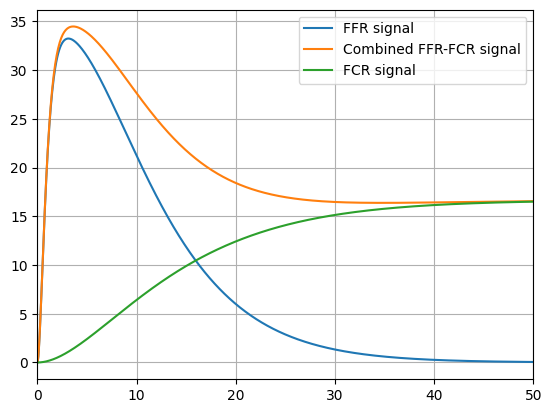

In [52]:
plt.plot(t, yffr_des, label='FFR signal')
plt.plot(t, yffr_fcr_des, label='Combined FFR-FCR signal')
plt.plot(t, yfcr_des, label='FCR signal')
plt.legend()
plt.grid()
plt.xlim(tlim)

# Individual Unit Response to services

## build PI and saturation block

In [112]:
# set saturation and PI parameters
saturation_limits = [-30, 30]
KP, KI = 20, 4
params = {}

In [113]:
# get sample systems: PV, Wind, BESS
# parameters from https://www.researchgate.net/publication/353419981_Automatic_Load_Frequency_Control_in_an_Isolated_Micro-grid_with_Superconducting_Magnetic_Energy_Storage_Unit_using_Integral_Controller
tau_PV, K_PV = 1.5, 1
tau_WTG, K_WTG = 2, 1
tau_BESS, K_BESS = 0.1, 1.5
taus = [tau_PV, tau_WTG, tau_BESS]
Kss = [K_PV, K_WTG, K_BESS]

names = ['PV', 'Wind', 'BESS']
for n in names:
    params[n] = {"kp": KP, "ki": KI}

Gs = {}  # transfer functions
for tau, K, name in zip(taus, Kss, names):
    G = ct.tf(K, [tau, 1], inputs=['u'], outputs=['y'])
    Gs[name] = G

In [114]:
# get hydro system from Verena paper
Rg, Rt = 0.03, 0.38
taug, taur, tauw = 0.2, 5, 1

def get_hydro_tf():
    T_hydro = -1/Rg / (taug*s + 1) * (taur*s+1) / (Rt/Rg*taur*s+1) * (1-tauw*s) / (1+1/2*tauw*s)
    return sympy_to_tf(sp.simplify(T_hydro))

T_hydro = get_hydro_tf() * Gs['Wind'] # add typical delay
T_hydro = ct.tf(T_hydro.num, T_hydro.den, inputs=['u'], outputs=['y'])
names.append('Hydro')
Gs['Hydro'] = T_hydro

# set pi params for hydro
params["Hydro"] = {"kp": -0.1, "ki": -0.02}

In [115]:
# get more advanced wind power model from "Dynamic Virtual Power Plant Design forFast Frequency Reserves: Coordinating Hydro and Wind" at https://www.research-collection.ethz.ch/server/api/core/bitstreams/208b9ae8-95ba-4bbf-abdb-c21a0c496068/content
wind_speed = 10  # example wind speed in m/s, below maximum power (note: Gotthard wind turbine the avg. wind speed is 11.8 m/s accoring to Global Wind Atlas)
zbar = 5.8 * wind_speed * 1e-3

def get_wind_zp_tf():
    T_wind_advanced = (s - zbar) / (s + zbar) #ct.tf([1, -zbar], [1, zbar], inputs=['u'], outputs=['y'])
    return sympy_to_tf(sp.simplify(T_wind_advanced))

T_wind_advanced = get_wind_zp_tf() * Gs['Wind'] # add typical delay
T_wind_advanced = ct.tf(T_wind_advanced.num, T_wind_advanced.den, inputs=['u'], outputs=['y'])

names.append('Wind (Adv)')
Gs['Wind (Adv)'] = T_wind_advanced

# set pi params
params["Wind (Adv)"] = {"kp": KP, "ki": KI}

now get the closed looped systems

In [116]:
def pi_update(t, x, u, params={}):
    ki = params.get('ki', 0.1)
    v = u[0]                    # meas
    vref = u[1]                 # reference 
    
    return vref - v

def pi_output(t, x, u, params={}):
    # Get the controller parameters that we need
    kp = params.get('kp')
    ki = params.get('ki')

    # Assign variables for inputs and states (for readability)
    v = u[0]                    # meas
    vref = u[1]                 # reference
    z = x[0]                    # integrated error

    # PI controller
    u_a = kp * (vref - v) + ki * z
    # saturation limits
    return np.clip(u_a, saturation_limits[0], saturation_limits[1])

def get_pi_controller(params={}):
    return ct.NonlinearIOSystem(
        pi_update, pi_output, name='control',
        inputs=['y', 'yref'], outputs=['u'], states=['z'],
        params=params)

PIs = {name: get_pi_controller(params=params[name]) for name in names}

# define error signal
#  create error
error = ct.summing_junction(['yref', '-y'], 'e')

# create closed-loop systems
Closed_Loop_systems = [ct.interconnect([PIs[name], Gs[name], error], inputs=['yref'], outputs=['y']) for name in names]

C:\Users\carlv\AppData\Roaming\Python\Python311\site-packages\control\nlsys.py:1197: UserWarning: Unused output(s) in InterconnectedSystem: (2, 0) : sys[358].e
  warn(msg)


## Start Plotting

In [117]:
def check_control_system(Gs: list, vref, names: list, title='', tlim=tlim):
    """
    Check the performance of the control system.
    Gs: list of interconnected system
    vref: reference to follow
    """
    t = np.linspace(tlim[0], tlim[1], 1000)    
    # Initial conditions: [PI integrator state, system state]
    x0 = [0, 0]

    # Plot results
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    plt.plot(t, vref, 'r--', label='Reference', linewidth=2)

    j = 0
    name = names[j]

    for closed_loop in Gs:
        name = names[j]
        # Simulate the closed-loop response
        response = ct.input_output_response(closed_loop, t, vref, x0)
    
        # Extract outputs and states properly
        plant_output = response.outputs.flatten() if response.outputs.ndim > 1 else response.outputs
        pi_state = response.states[0] if response.states.ndim > 1 else response.states
        pv_state = response.states[1] if response.states.ndim > 1 and response.states.shape[0] > 1 else response.states
    
        # # Debug: Print shapes to understand the data structure
        # print(f"Time shape: {t.shape}")
        # print(f"Response outputs shape: {response.outputs.shape}")
        # print(f"Response states shape: {response.states.shape}")

        plt.subplot(2, 1, 1)
        plt.plot(t, plant_output, linewidth=1.5, label=f'{name}')

        # second plot
        plt.subplot(2, 1, 2)
        if response.states.ndim > 1:
            plt.plot(t, response.states[0],  linewidth=2, label=f'{name} PI State')
            if response.states.shape[0] > 1:
                plt.plot(t, response.states[1], linewidth=2, label=f'{name} System State')
        else:
            plt.plot(t, response.states, 'g-', linewidth=2)
        
    
        # Print some performance metrics
        print(f"Metrics for {name}:")
        final_output = plant_output[-1] if hasattr(plant_output, '__len__') else plant_output
        steady_state_error = abs(vref[-1] - final_output)
        print(f"Steady-state error: {steady_state_error:.4f}")
    
        # Find settling time (within 2% of final value)
        if hasattr(plant_output, '__len__') and len(plant_output) > 1:
            final_value = plant_output[-1]
            settling_idx = np.where(np.abs(plant_output - final_value) <= 0.02 * abs(final_value))[0]
            if len(settling_idx) > 0:
                settling_time = t[settling_idx[0]]
                print(f"Settling time (2%): {settling_time:.2f} seconds")
            
            # Check for overshoot
            max_output = np.max(plant_output)
            overshoot = max(0, (max_output - final_value) / final_value * 100)
            print(f"Overshoot: {overshoot:.2f}%")
        else:
            print("Cannot compute performance metrics - output is scalar")
        j += 1
        print('========================================')

    plt.subplot(2, 1, 1)
    plt.legend()
    plt.title(title)
    plt.grid(True)
    plt.xlim(tlim)

    plt.subplot(2, 1, 2)
    plt.xlim(tlim)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    plt.show()    

## VQ Response

Metrics for PV:
Steady-state error: 0.0169
Settling time (2%): 2.40 seconds
Overshoot: 0.09%
Metrics for Wind:
Steady-state error: 0.2389
Settling time (2%): 1.82 seconds
Overshoot: 0.18%
Metrics for BESS:
Steady-state error: 0.2127
Settling time (2%): 2.74 seconds
Overshoot: 0.09%
Metrics for Hydro:
Steady-state error: 10.8795
Settling time (2%): 4.93 seconds
Overshoot: 0.00%
Metrics for Wind (Adv):
Steady-state error: 0.1006
Settling time (2%): 1.98 seconds
Overshoot: 0.95%


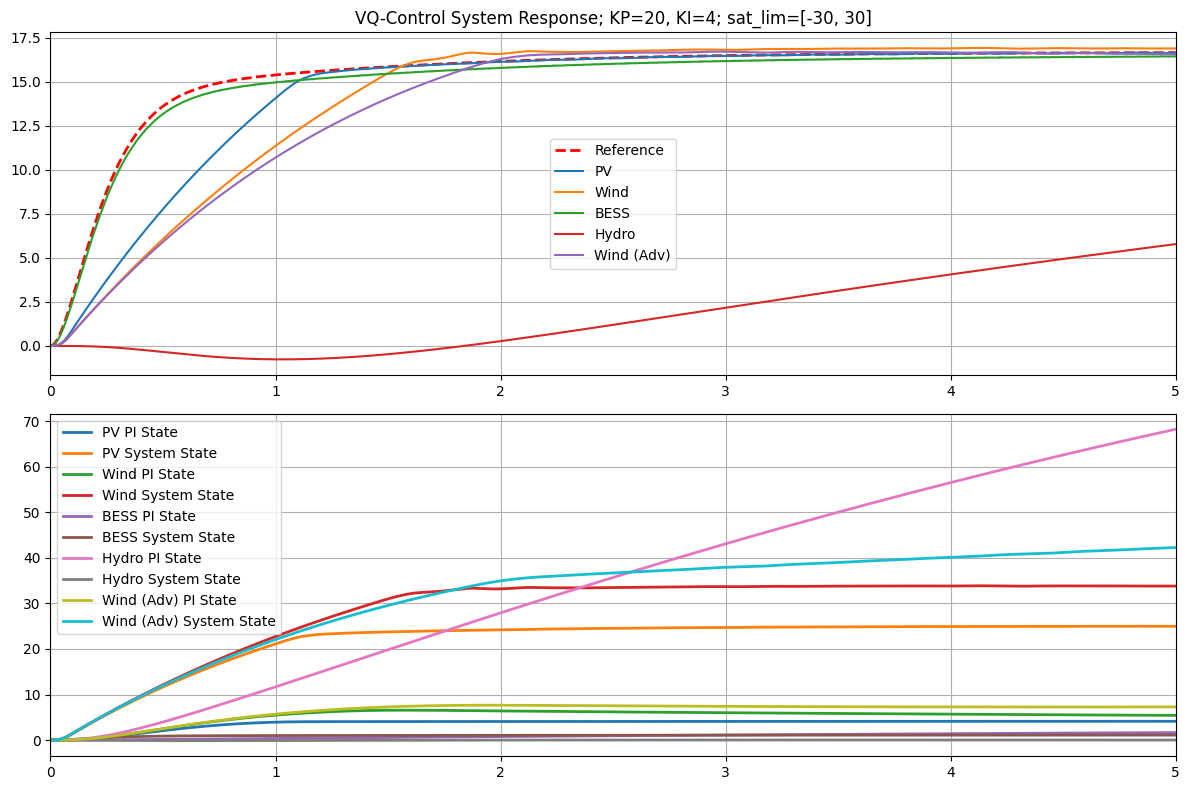

In [118]:
check_control_system(Closed_Loop_systems, yvq, names, tlim=[0,5], title=f'VQ-Control System Response; KP={KP}, KI={KI}; sat_lim={saturation_limits}')

## FCR response

check if devices can match FCR

Metrics for PV:
Steady-state error: 0.3144
Settling time (2%): 4.16 seconds
Overshoot: 0.00%
Metrics for Wind:
Steady-state error: 0.2800
Settling time (2%): 4.17 seconds
Overshoot: 0.00%
Metrics for BESS:
Steady-state error: 0.2669
Settling time (2%): 4.12 seconds
Overshoot: 0.03%
Metrics for Hydro:
Steady-state error: 12.6437
Settling time (2%): 4.96 seconds
Overshoot: 0.00%
Metrics for Wind (Adv):
Steady-state error: 0.6456
Settling time (2%): 4.07 seconds
Overshoot: 0.00%


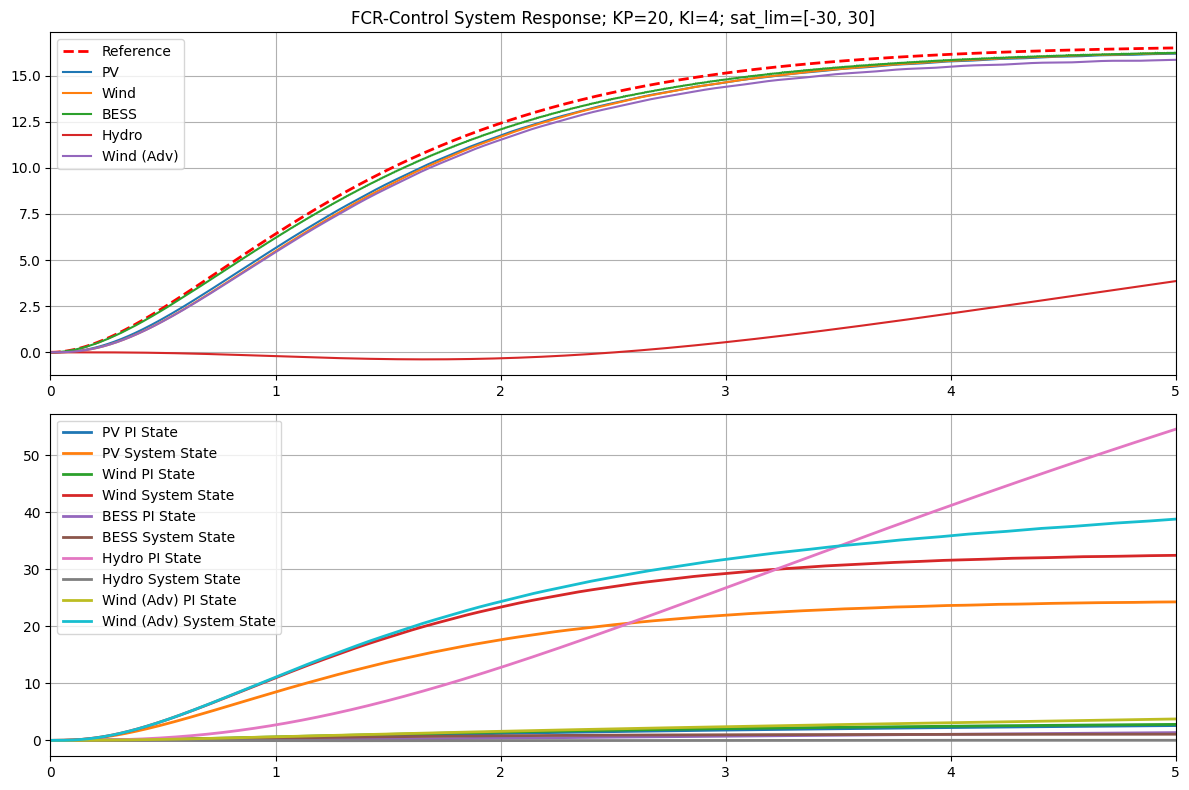

In [120]:
# check_control_system(closed_loop, yfcr_verena, title="Response to FCR Signal Input")
check_control_system(Closed_Loop_systems, yfcr_verena, names, tlim=[0,5], title=f'FCR-Control System Response; KP={KP}, KI={KI}; sat_lim={saturation_limits}')

## FFR-FCR Response

Metrics for PV:
Steady-state error: 2.2480
Settling time (2%): 1.44 seconds
Overshoot: 17.61%
Metrics for Wind:
Steady-state error: 2.8877
Settling time (2%): 2.03 seconds
Overshoot: 10.10%
Metrics for BESS:
Steady-state error: 0.1538
Settling time (2%): 0.09 seconds
Overshoot: 104.02%
Metrics for Hydro:
Steady-state error: 8.1769
Settling time (2%): 4.87 seconds
Overshoot: 0.00%
Metrics for Wind (Adv):
Steady-state error: 1.1347
Settling time (2%): 2.29 seconds
Overshoot: 6.42%


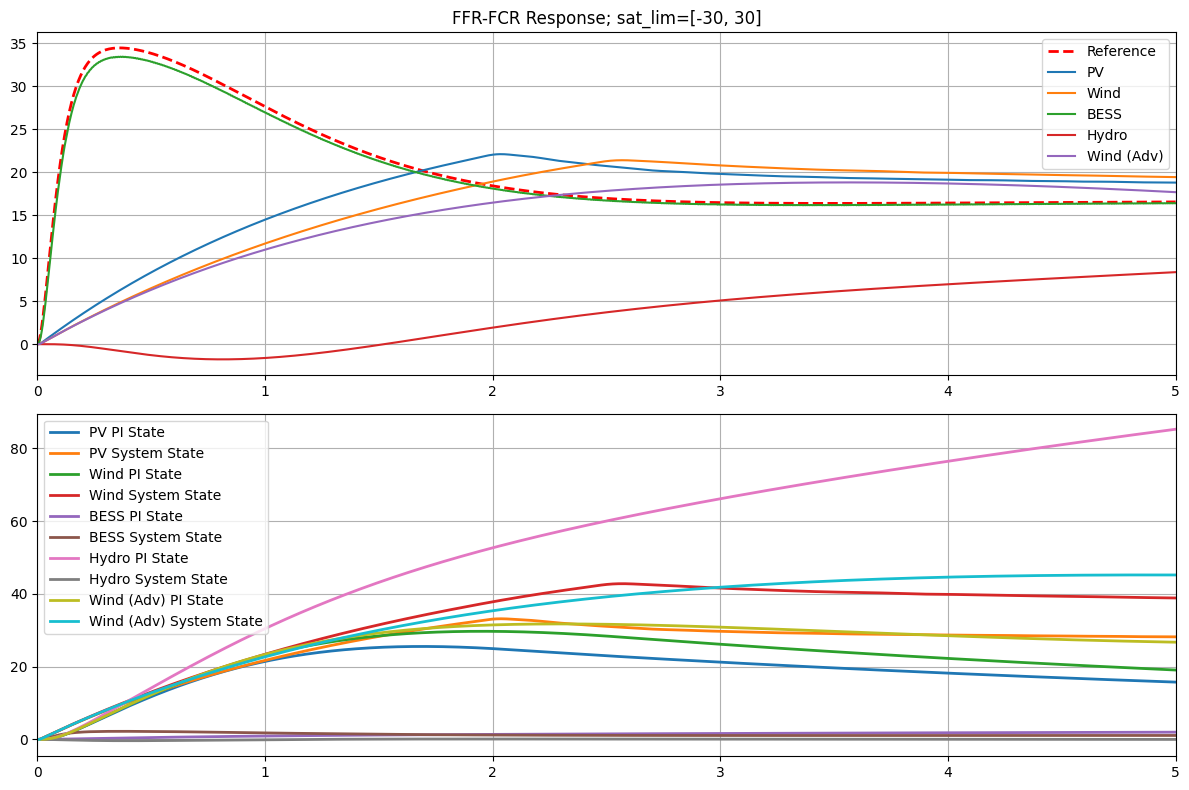

In [121]:
check_control_system(Closed_Loop_systems, yffr_fcr_des, names, tlim=[0,5], title=f'FFR-FCR Response; sat_lim={saturation_limits}')

# Aggregated Unit responses

In [122]:
import itertools

C:\Users\carlv\AppData\Roaming\Python\Python311\site-packages\control\nlsys.py:1197: UserWarning: Unused output(s) in InterconnectedSystem: (5, 0) : sys[370].e
  warn(msg)


Metrics for PV + Wind:
Steady-state error: 1.1698
Settling time (2%): 0.60 seconds
Overshoot: 59.24%


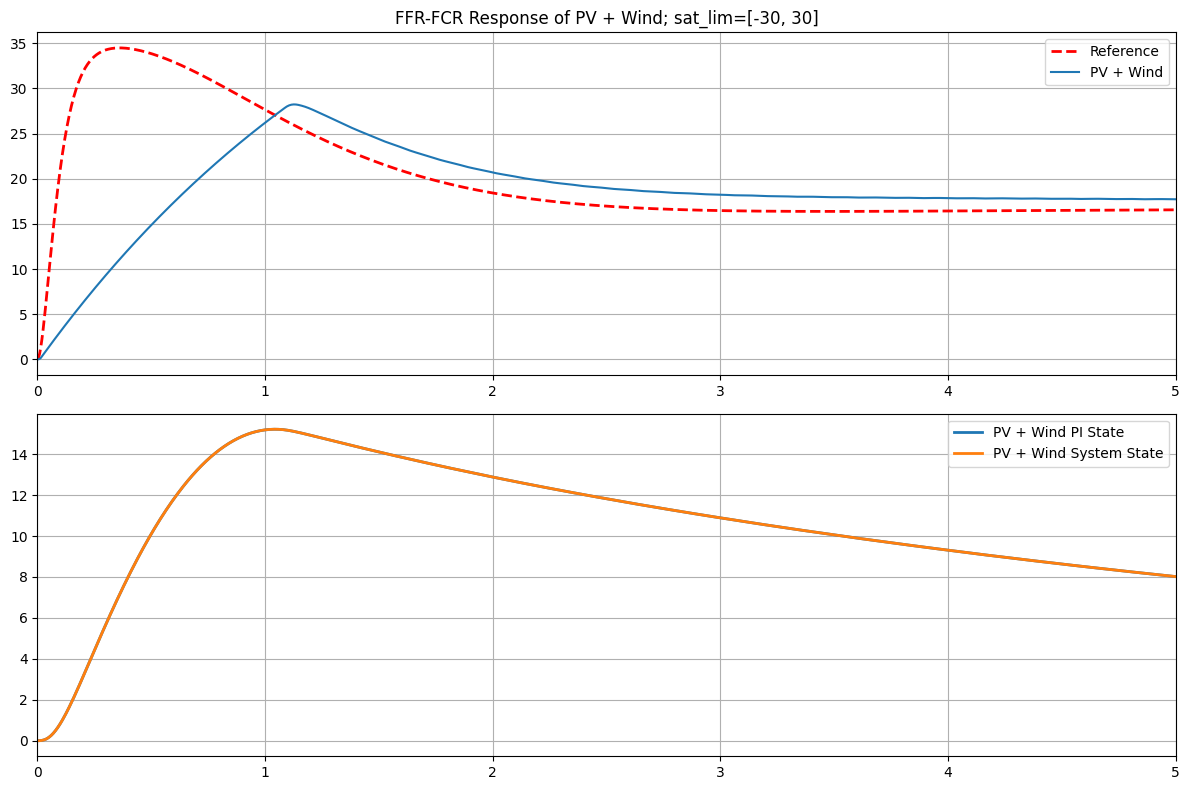

C:\Users\carlv\AppData\Roaming\Python\Python311\site-packages\control\nlsys.py:1197: UserWarning: Unused output(s) in InterconnectedSystem: (5, 0) : sys[375].e
  warn(msg)


Metrics for PV + BESS:
Steady-state error: 0.0815
Settling time (2%): 0.09 seconds
Overshoot: 104.14%


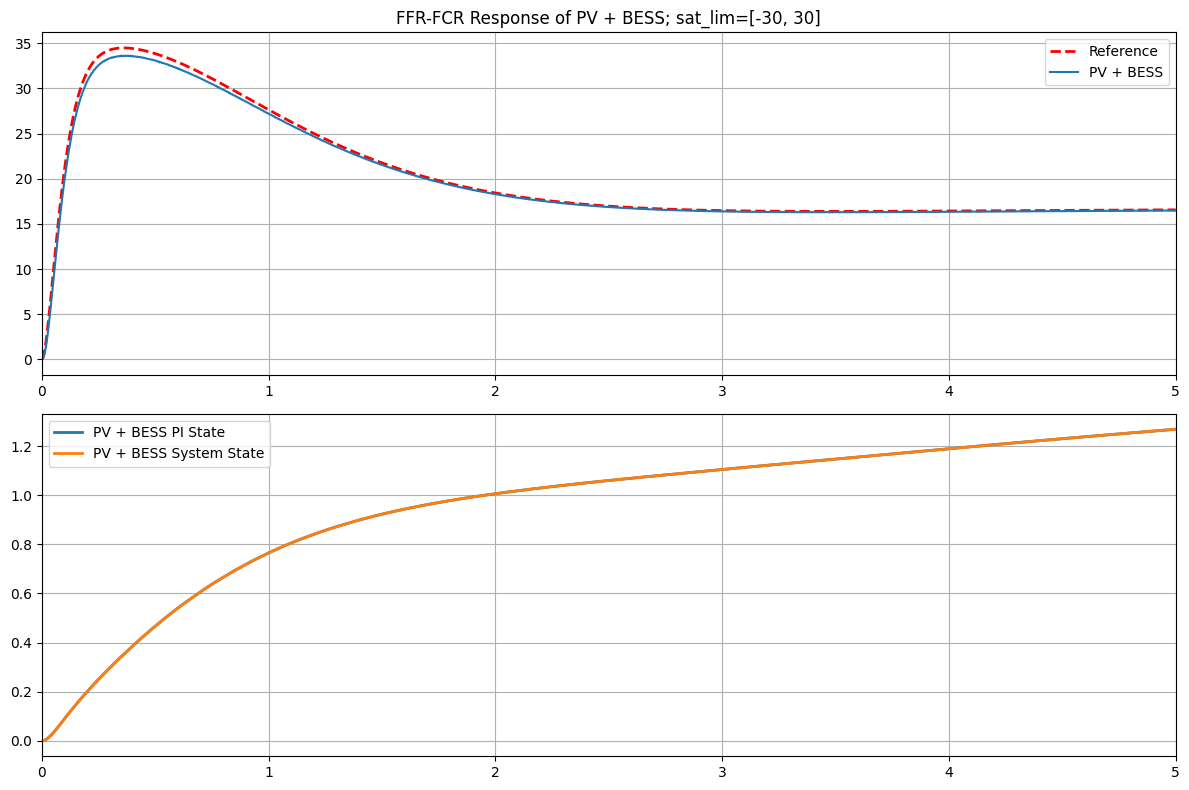

C:\Users\carlv\AppData\Roaming\Python\Python311\site-packages\control\nlsys.py:1197: UserWarning: Unused output(s) in InterconnectedSystem: (5, 0) : sys[380].e
  warn(msg)


Metrics for PV + Hydro:
Steady-state error: 2.3048
Settling time (2%): 1.42 seconds
Overshoot: 22.78%


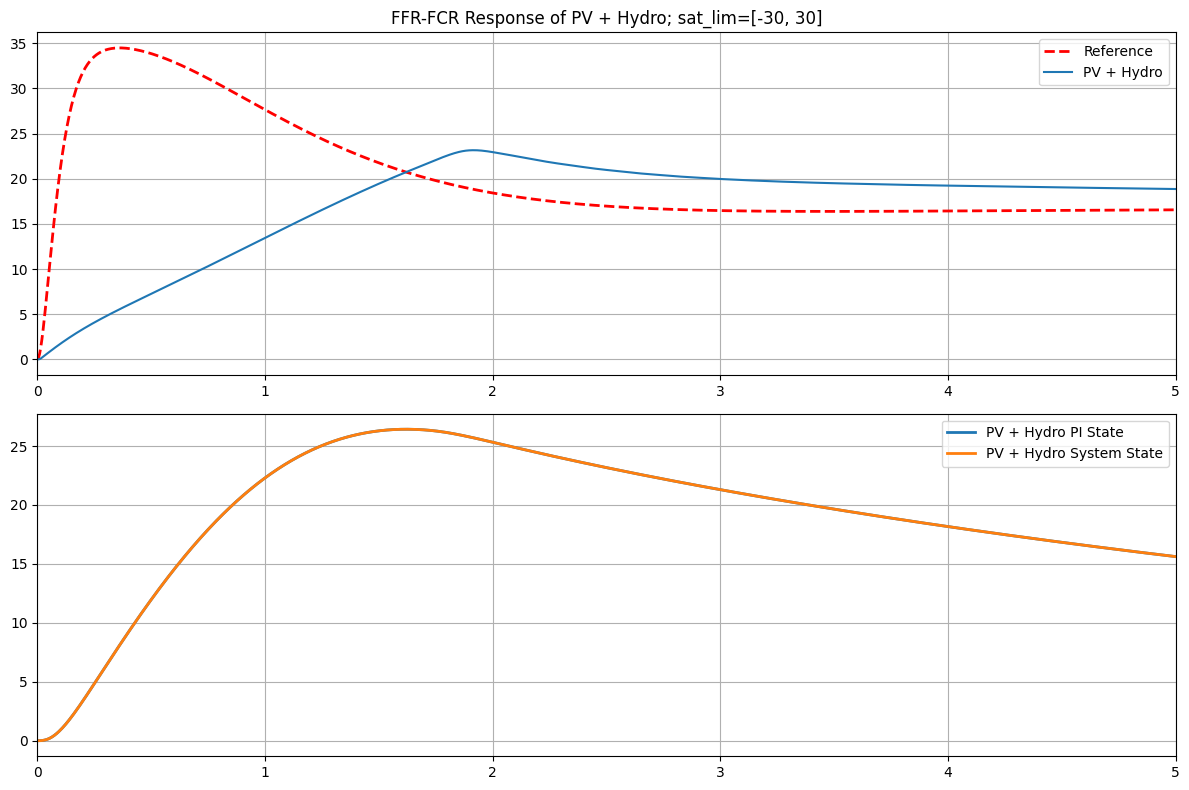

C:\Users\carlv\AppData\Roaming\Python\Python311\site-packages\control\nlsys.py:1197: UserWarning: Unused output(s) in InterconnectedSystem: (5, 0) : sys[385].e
  warn(msg)


Metrics for PV + Wind (Adv):
Steady-state error: 1.1084
Settling time (2%): 0.61 seconds
Overshoot: 57.45%


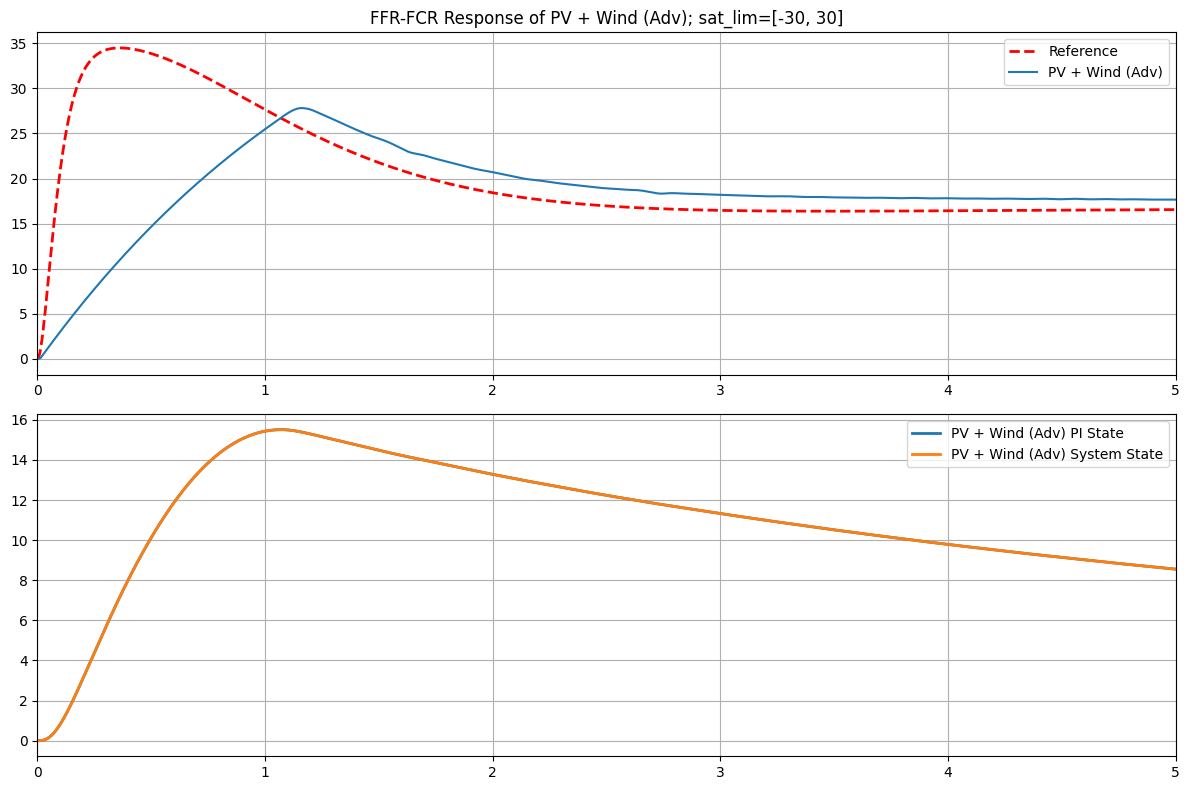

C:\Users\carlv\AppData\Roaming\Python\Python311\site-packages\control\nlsys.py:1197: UserWarning: Unused output(s) in InterconnectedSystem: (5, 0) : sys[390].e
  warn(msg)


Metrics for Wind + BESS:
Steady-state error: 0.0704
Settling time (2%): 0.09 seconds
Overshoot: 103.80%


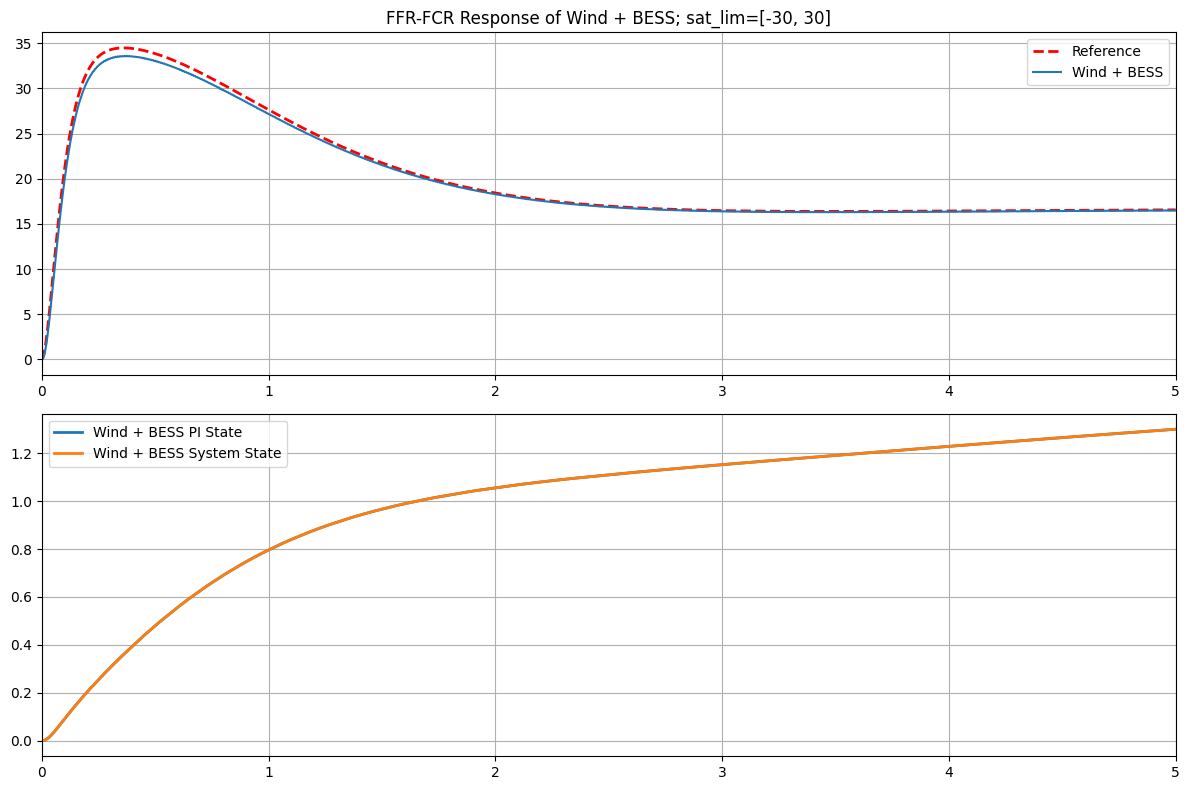

C:\Users\carlv\AppData\Roaming\Python\Python311\site-packages\control\nlsys.py:1197: UserWarning: Unused output(s) in InterconnectedSystem: (5, 0) : sys[395].e
  warn(msg)


Metrics for Wind + Hydro:
Steady-state error: 2.8586
Settling time (2%): 1.78 seconds
Overshoot: 16.40%


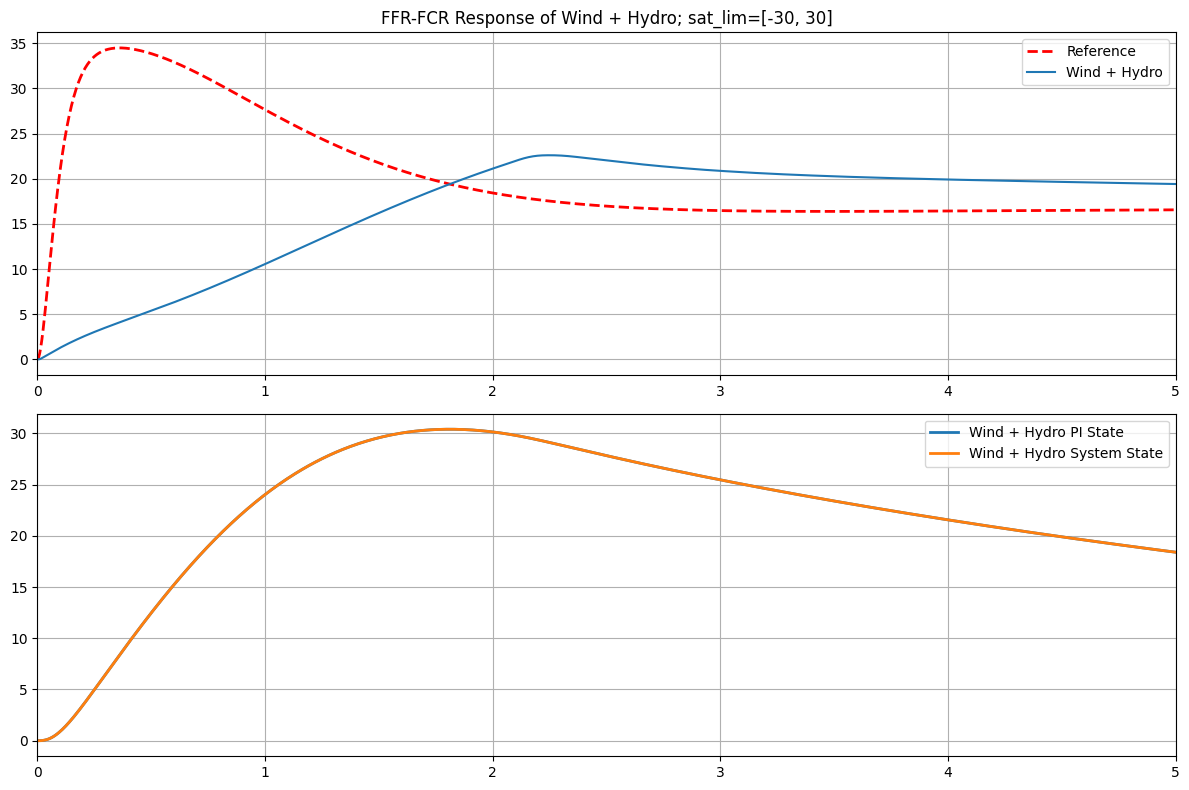

C:\Users\carlv\AppData\Roaming\Python\Python311\site-packages\control\nlsys.py:1197: UserWarning: Unused output(s) in InterconnectedSystem: (5, 0) : sys[400].e
  warn(msg)


Metrics for Wind + Wind (Adv):
Steady-state error: 1.3100
Settling time (2%): 0.72 seconds
Overshoot: 49.85%


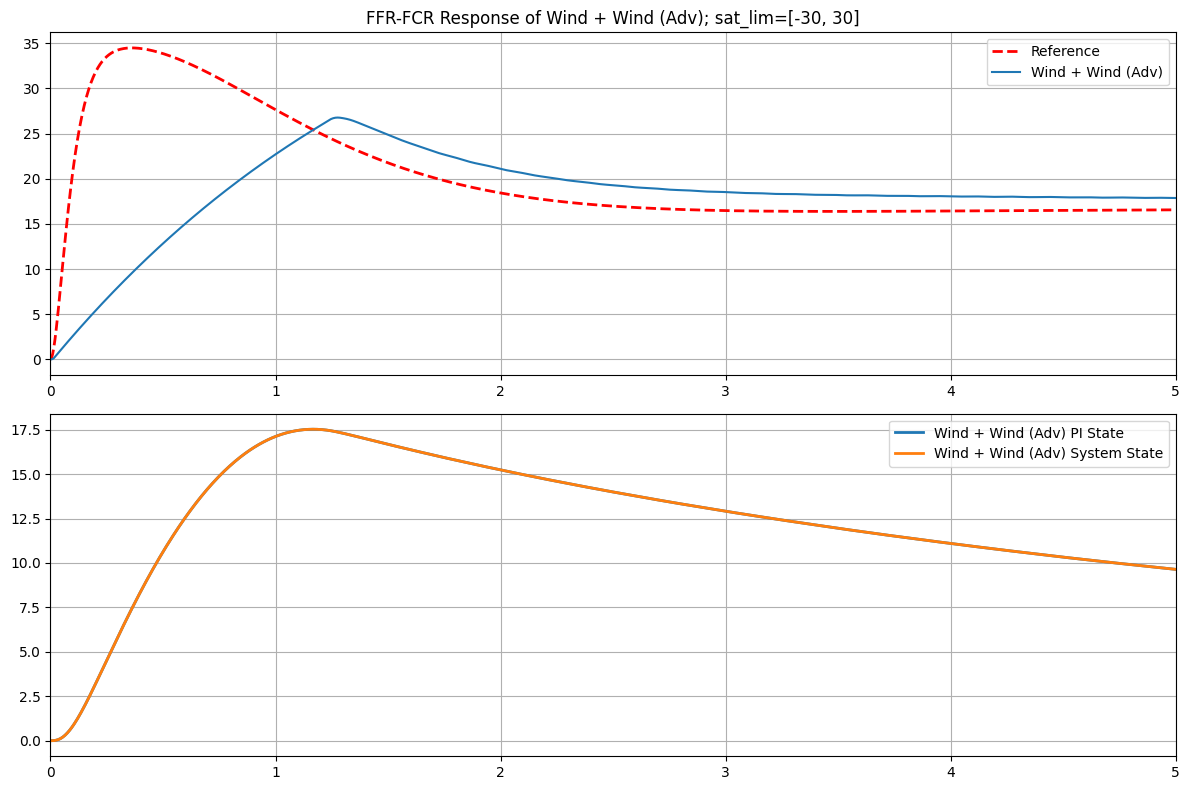

C:\Users\carlv\AppData\Roaming\Python\Python311\site-packages\control\nlsys.py:1197: UserWarning: Unused output(s) in InterconnectedSystem: (5, 0) : sys[405].e
  warn(msg)


Metrics for BESS + Hydro:
Steady-state error: 0.1446
Settling time (2%): 0.09 seconds
Overshoot: 103.92%


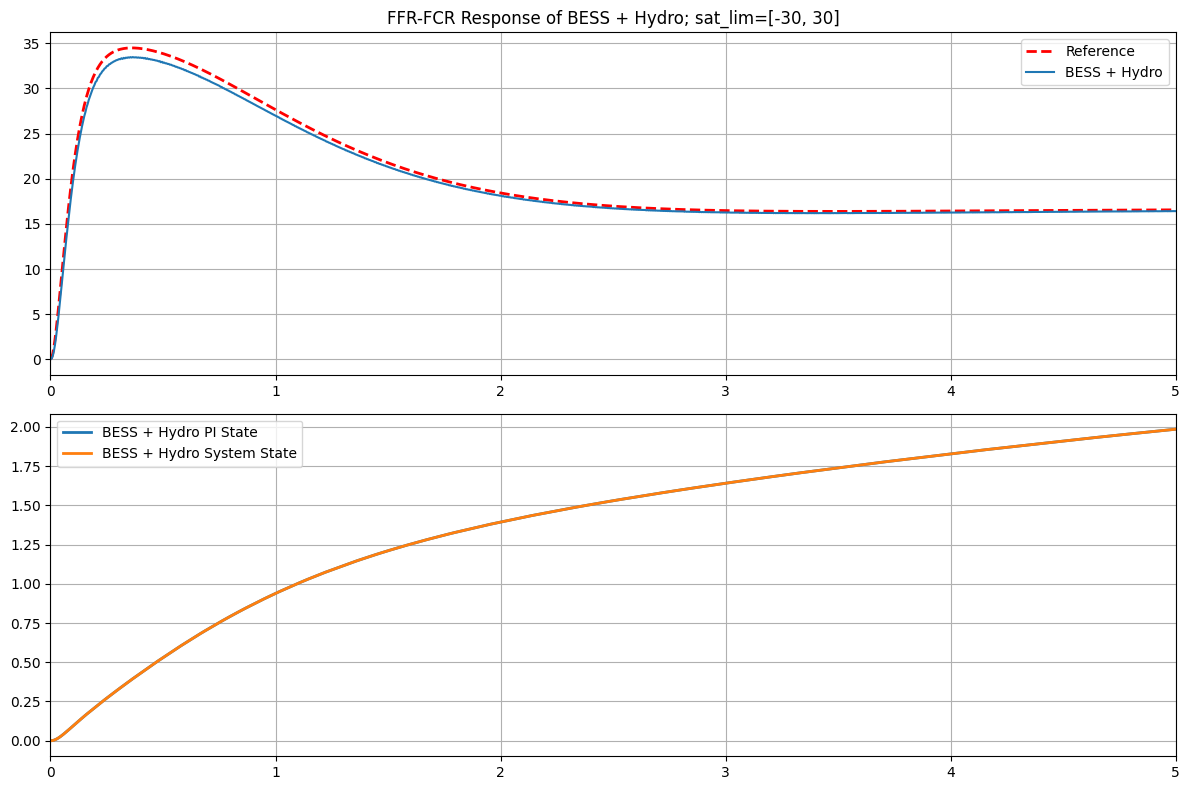

C:\Users\carlv\AppData\Roaming\Python\Python311\site-packages\control\nlsys.py:1197: UserWarning: Unused output(s) in InterconnectedSystem: (5, 0) : sys[410].e
  warn(msg)


Metrics for BESS + Wind (Adv):
Steady-state error: 0.1216
Settling time (2%): 0.09 seconds
Overshoot: 104.39%


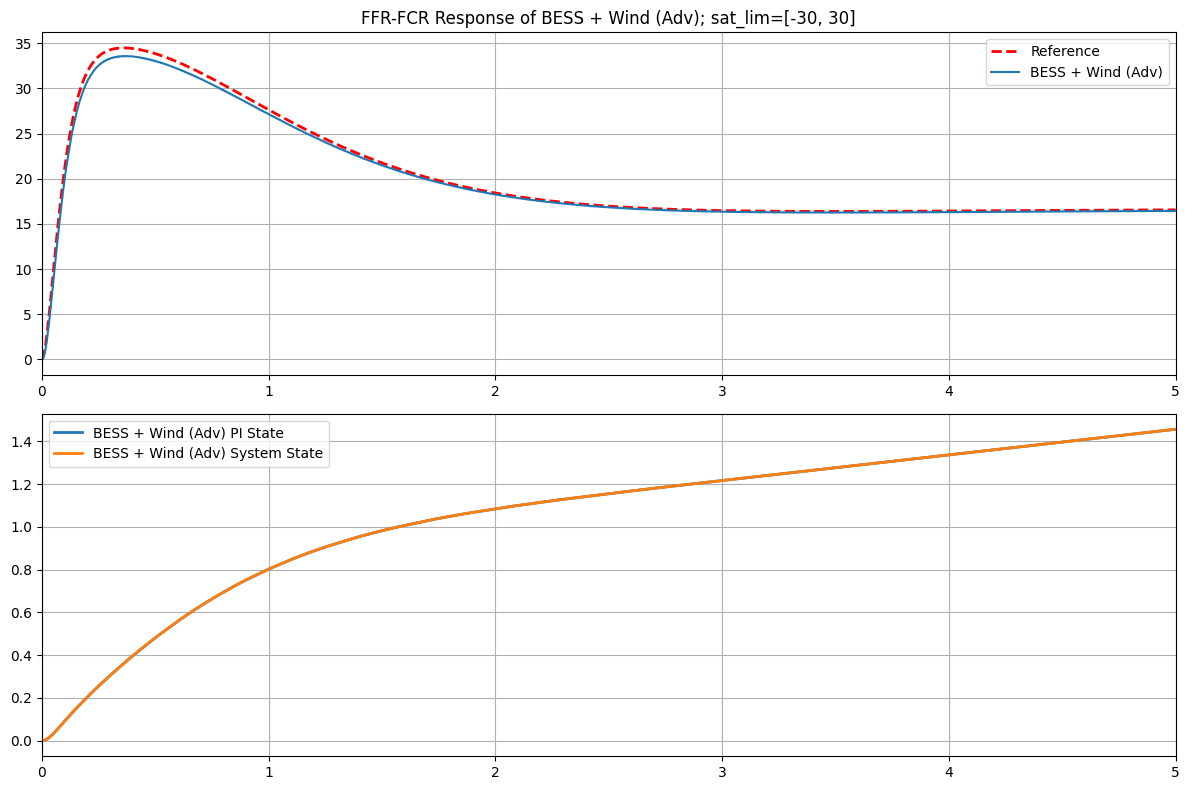

C:\Users\carlv\AppData\Roaming\Python\Python311\site-packages\control\nlsys.py:1197: UserWarning: Unused output(s) in InterconnectedSystem: (5, 0) : sys[415].e
  warn(msg)


Metrics for Hydro + Wind (Adv):
Steady-state error: 2.7589
Settling time (2%): 2.05 seconds
Overshoot: 11.53%


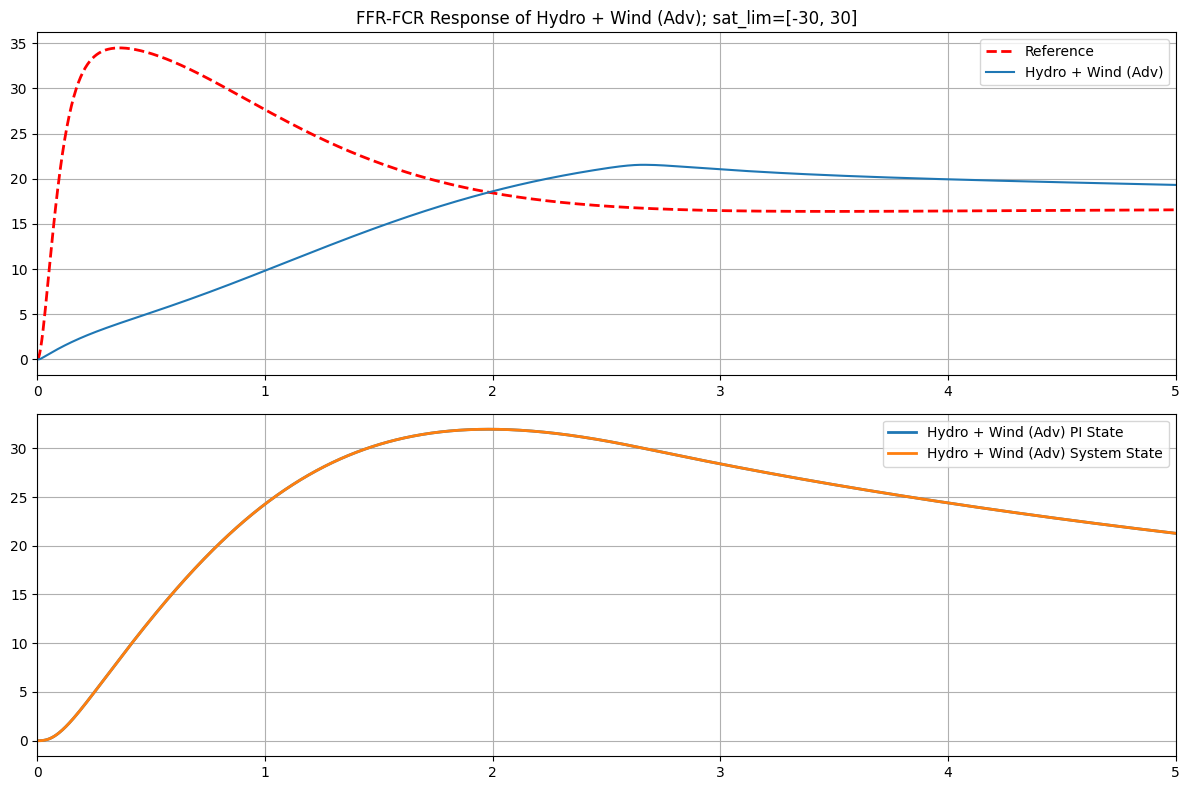

In [123]:
# aggregate 2 units
for subset in itertools.combinations(names, 2):
    name1, name2 = subset
    G1, G2 = Gs[name1], Gs[name2]
    # rename for new closed loop
    G1.output_labels = ['y1']
    G1.name = name1
    G2.output_labels = ['y2']
    G2.name = name2
    y_total = ct.summing_junction(['y1', 'y2'], 'y')  # create new total output
    error = ct.summing_junction(['yref', '-y'], 'e')  # error signal
    PI1, PI2 = PIs[name1], PIs[name2]  # get PI controller
    PI1.output_labels = ['u1']
    PI1.name = f'PI_{name1}'
    PI2.output_labels = ['u2']
    PI2.name = f'PI_{name2}'
    G1.input_labels = ['u1']
    G2.input_labels = ['u2']

    closed_loop_agg = ct.interconnect([PI1, PI2, G1, G2, y_total, error], inputs=['yref'], outputs=['y'])
    name_agg = f'{name1} + {name2}'

    check_control_system([closed_loop_agg], yffr_fcr_des, [name_agg], tlim=[0,5], title=f'FFR-FCR Response of {name_agg}; sat_lim={saturation_limits}')

C:\Users\carlv\AppData\Roaming\Python\Python311\site-packages\control\nlsys.py:1191: UserWarning: Unused input(s) in InterconnectedSystem: (4, 0)=BESS.u3
  warn(msg)
C:\Users\carlv\AppData\Roaming\Python\Python311\site-packages\control\nlsys.py:1197: UserWarning: Unused output(s) in InterconnectedSystem: (6, 0) : sys[420].e
  warn(msg)


Metrics for PV + Wind + BESS:
Steady-state error: 1.1706
Settling time (2%): 0.60 seconds
Overshoot: 59.32%


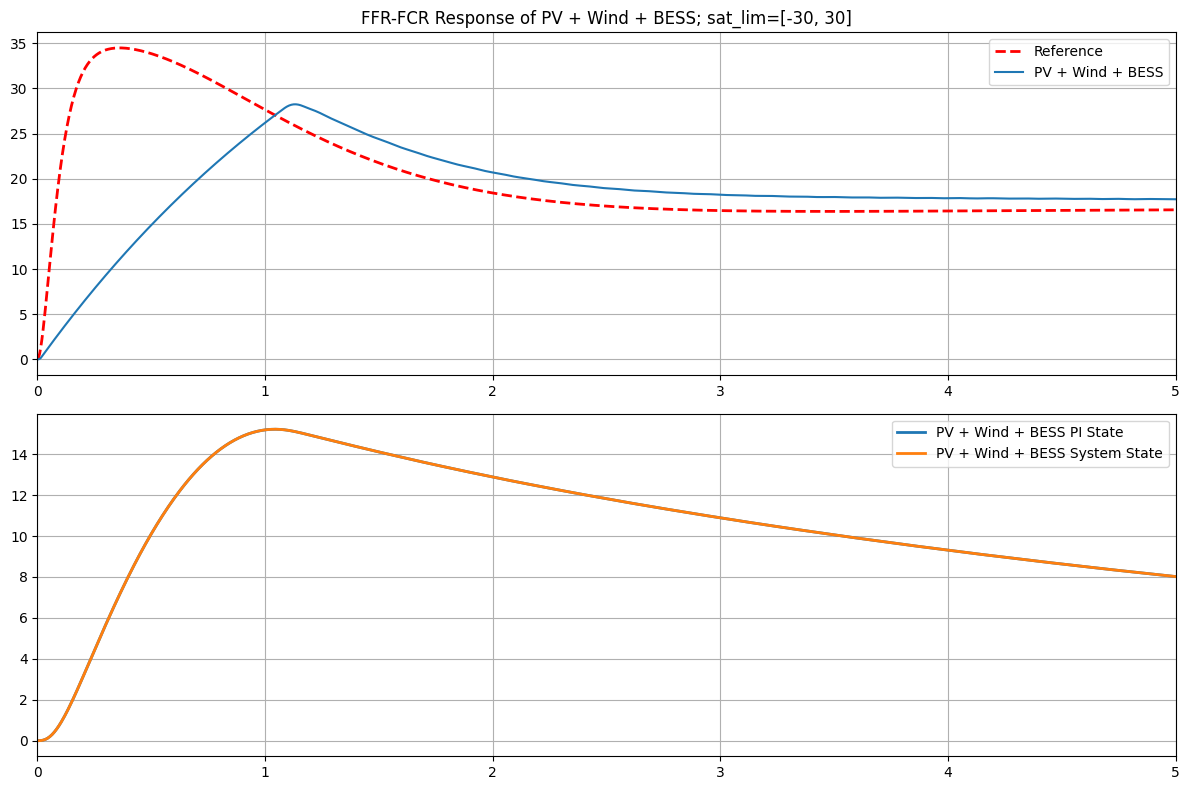

C:\Users\carlv\AppData\Roaming\Python\Python311\site-packages\control\nlsys.py:1191: UserWarning: Unused input(s) in InterconnectedSystem: (4, 0)=Hydro.u3
  warn(msg)
C:\Users\carlv\AppData\Roaming\Python\Python311\site-packages\control\nlsys.py:1197: UserWarning: Unused output(s) in InterconnectedSystem: (6, 0) : sys[426].e
  warn(msg)


Metrics for PV + Wind + Hydro:
Steady-state error: 1.1744
Settling time (2%): 0.60 seconds
Overshoot: 59.11%


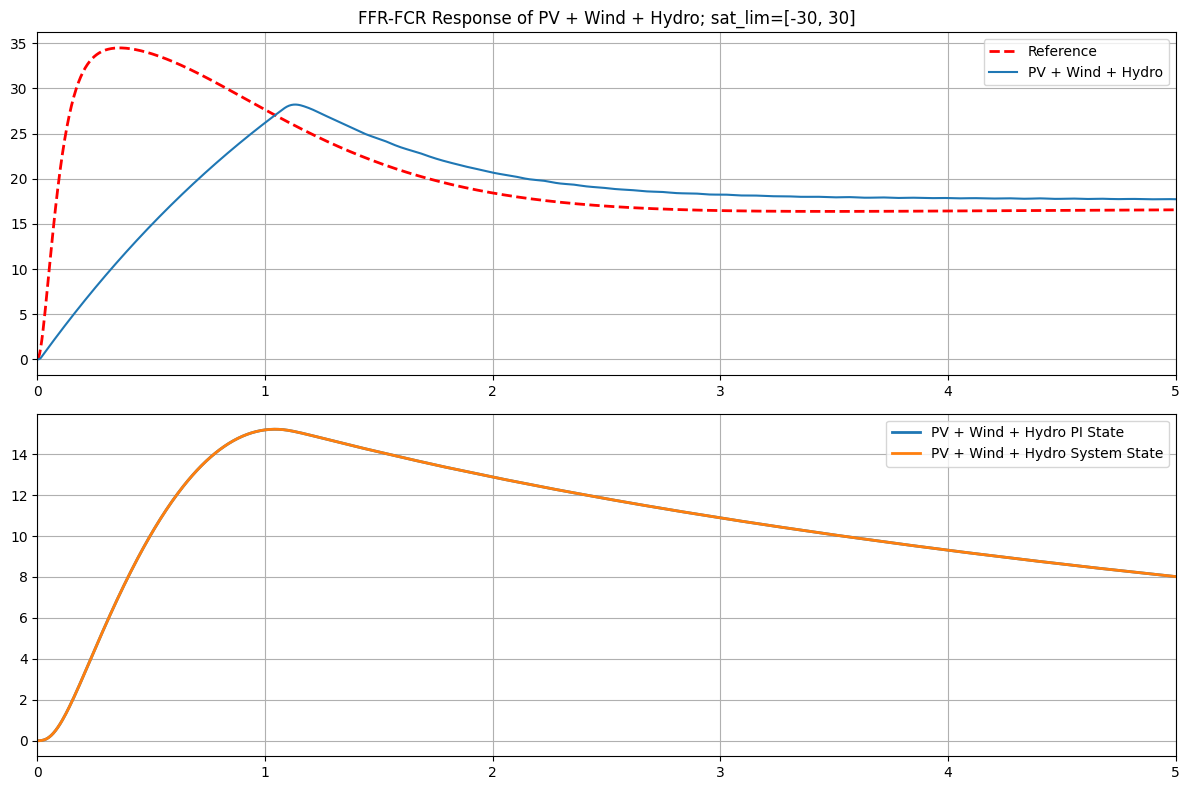

C:\Users\carlv\AppData\Roaming\Python\Python311\site-packages\control\nlsys.py:1191: UserWarning: Unused input(s) in InterconnectedSystem: (4, 0)=Wind (Adv).u3
  warn(msg)
C:\Users\carlv\AppData\Roaming\Python\Python311\site-packages\control\nlsys.py:1197: UserWarning: Unused output(s) in InterconnectedSystem: (6, 0) : sys[432].e
  warn(msg)


Metrics for PV + Wind + Wind (Adv):
Steady-state error: 1.1842
Settling time (2%): 0.60 seconds
Overshoot: 59.09%


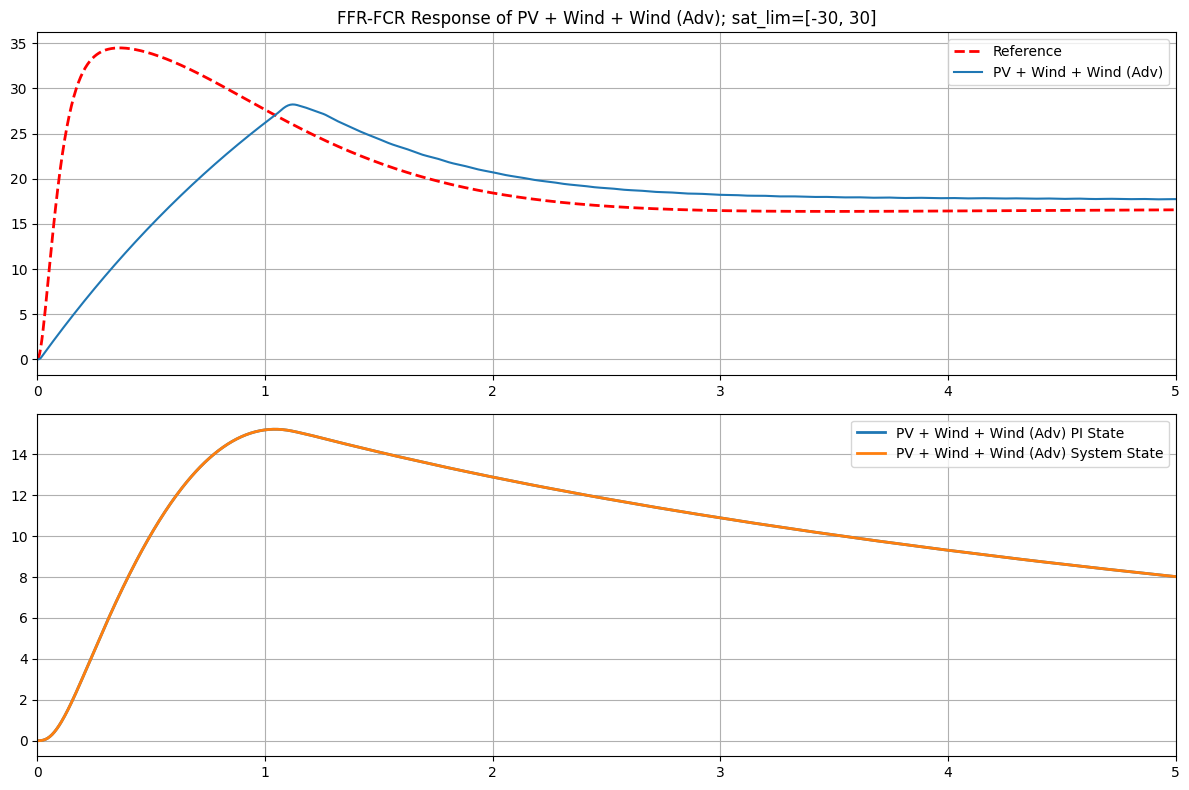

C:\Users\carlv\AppData\Roaming\Python\Python311\site-packages\control\nlsys.py:1197: UserWarning: Unused output(s) in InterconnectedSystem: (6, 0) : sys[438].e
  warn(msg)


Metrics for PV + BESS + Hydro:
Steady-state error: 0.0850
Settling time (2%): 0.09 seconds
Overshoot: 104.34%


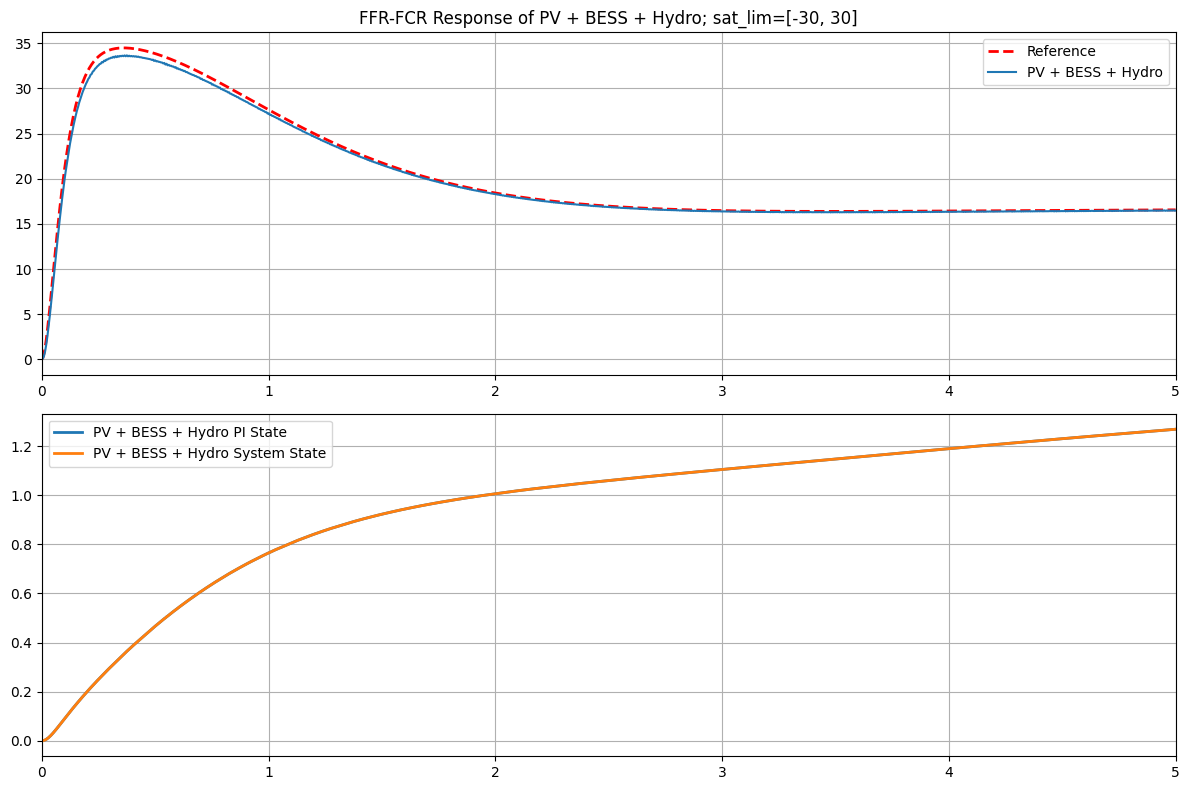

C:\Users\carlv\AppData\Roaming\Python\Python311\site-packages\control\nlsys.py:1197: UserWarning: Unused output(s) in InterconnectedSystem: (6, 0) : sys[444].e
  warn(msg)


Metrics for PV + BESS + Wind (Adv):
Steady-state error: 0.0823
Settling time (2%): 0.09 seconds
Overshoot: 104.30%


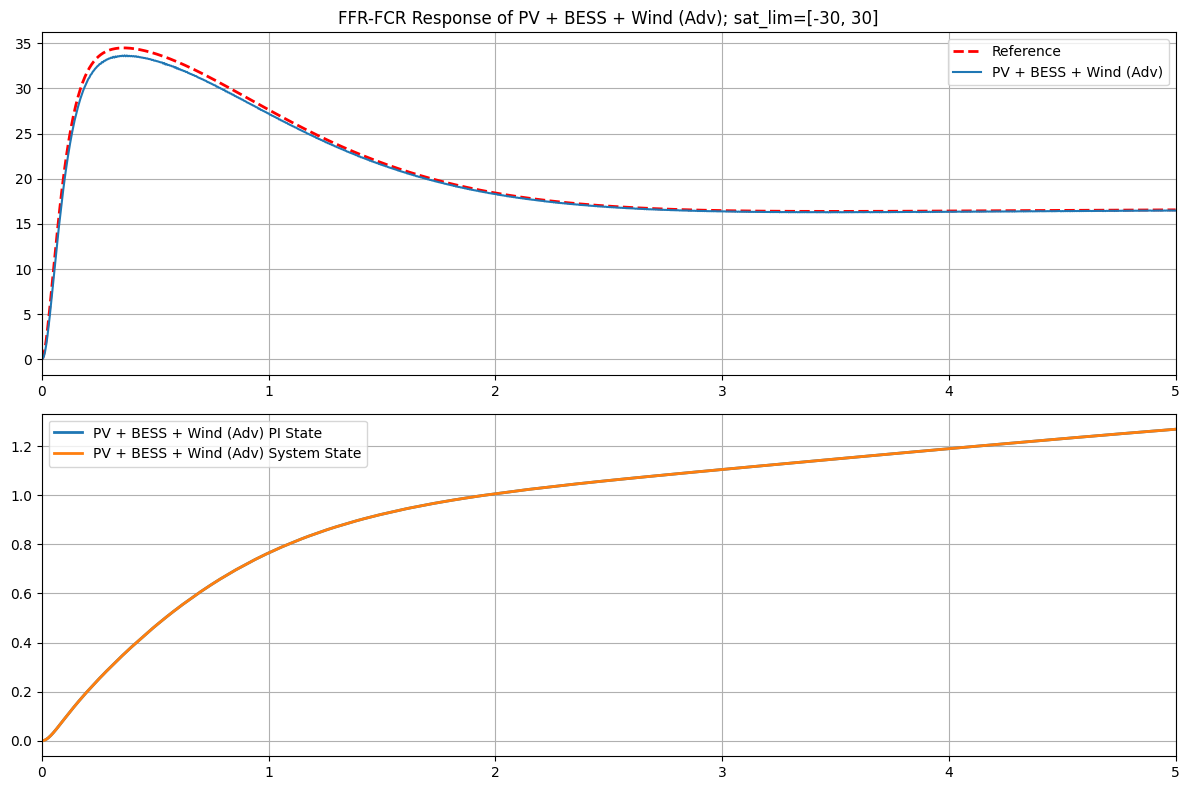

C:\Users\carlv\AppData\Roaming\Python\Python311\site-packages\control\nlsys.py:1197: UserWarning: Unused output(s) in InterconnectedSystem: (6, 0) : sys[450].e
  warn(msg)


Metrics for PV + Hydro + Wind (Adv):
Steady-state error: 2.3052
Settling time (2%): 1.42 seconds
Overshoot: 22.60%


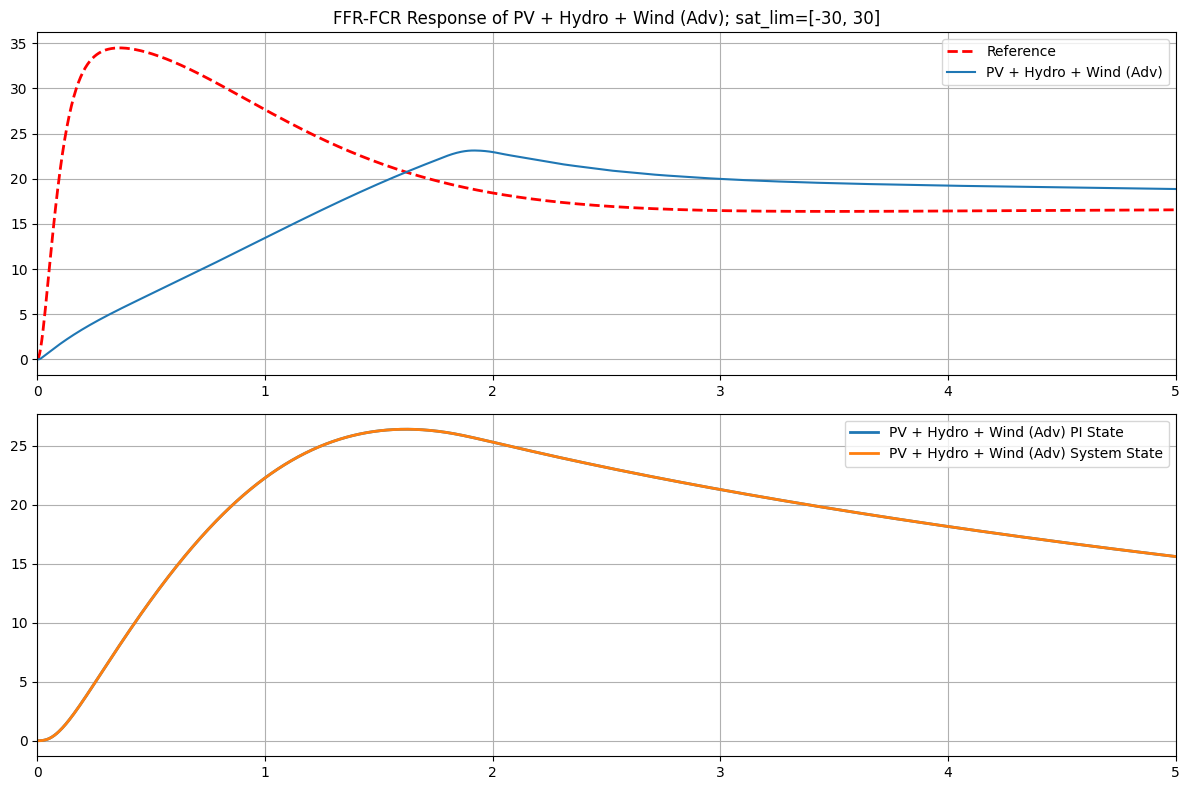

C:\Users\carlv\AppData\Roaming\Python\Python311\site-packages\control\nlsys.py:1197: UserWarning: Unused output(s) in InterconnectedSystem: (6, 0) : sys[456].e
  warn(msg)


Metrics for Wind + BESS + Hydro:
Steady-state error: 0.0723
Settling time (2%): 0.09 seconds
Overshoot: 103.83%


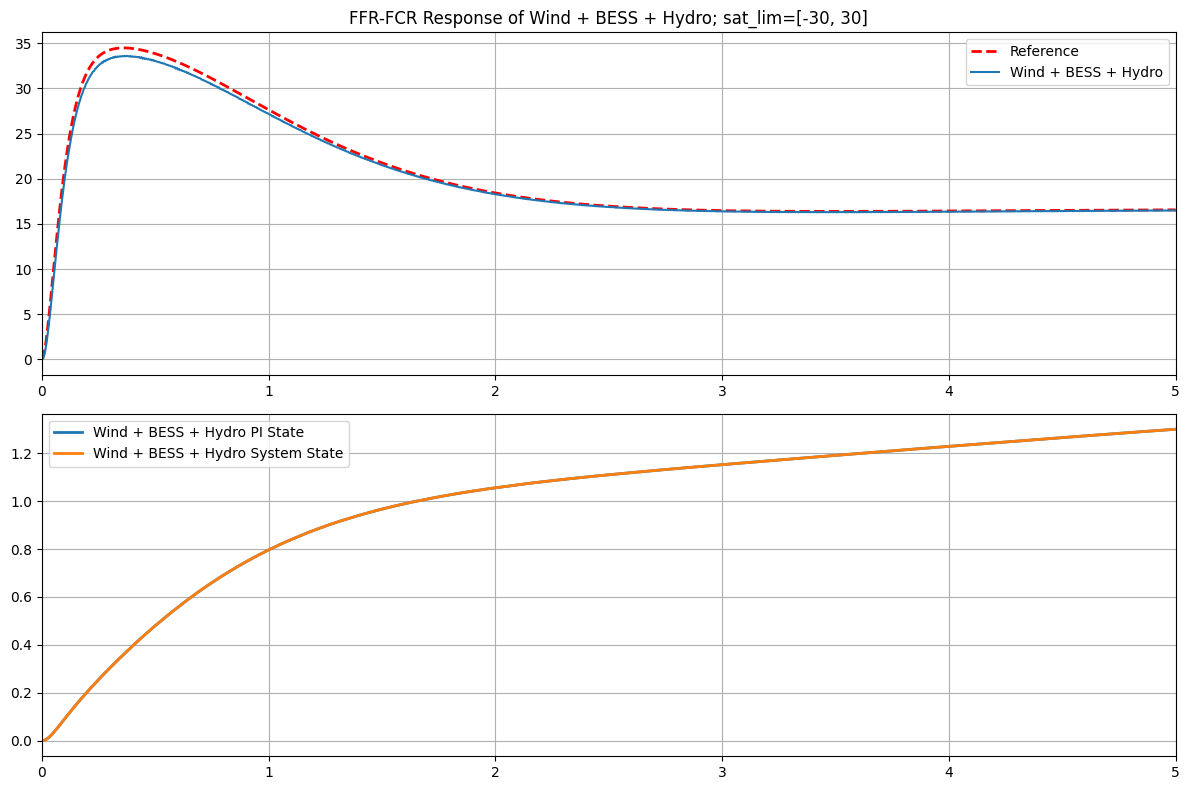

C:\Users\carlv\AppData\Roaming\Python\Python311\site-packages\control\nlsys.py:1197: UserWarning: Unused output(s) in InterconnectedSystem: (6, 0) : sys[462].e
  warn(msg)


Metrics for Wind + BESS + Wind (Adv):
Steady-state error: 0.0715
Settling time (2%): 0.09 seconds
Overshoot: 103.83%


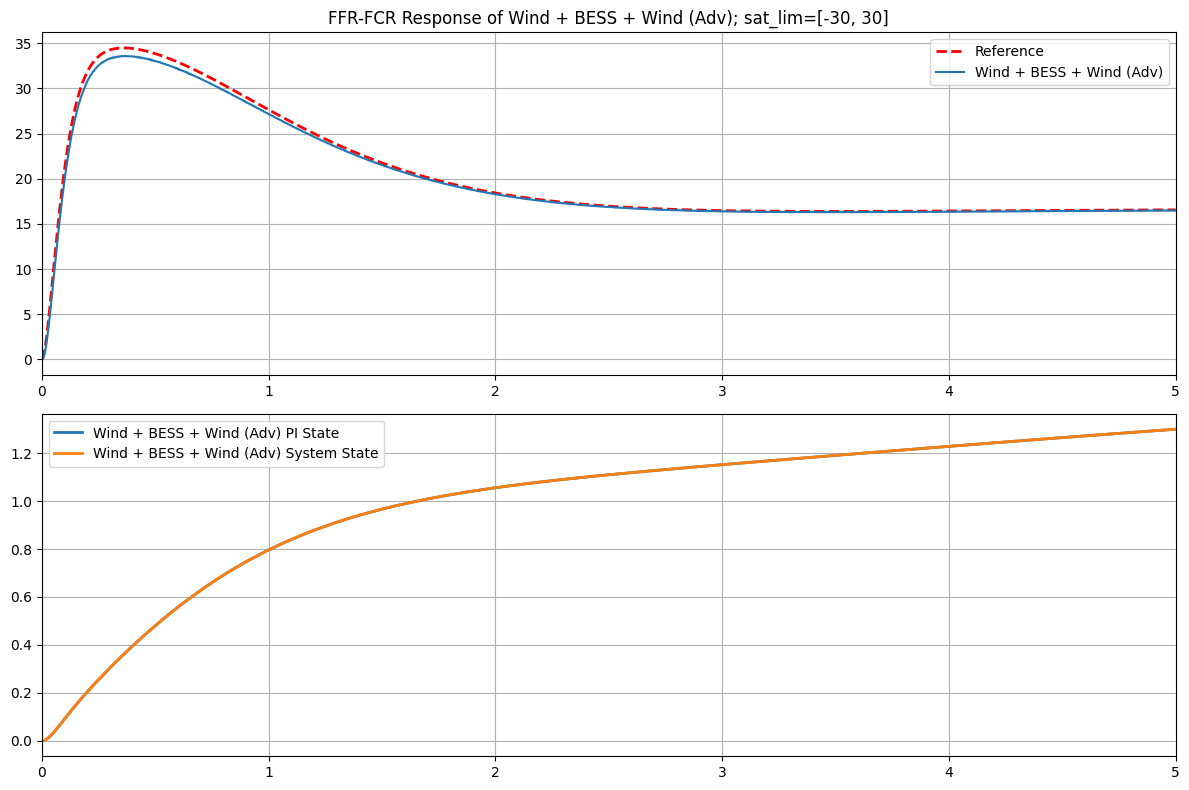

C:\Users\carlv\AppData\Roaming\Python\Python311\site-packages\control\nlsys.py:1197: UserWarning: Unused output(s) in InterconnectedSystem: (6, 0) : sys[468].e
  warn(msg)


Metrics for Wind + Hydro + Wind (Adv):
Steady-state error: 2.8581
Settling time (2%): 1.78 seconds
Overshoot: 16.49%


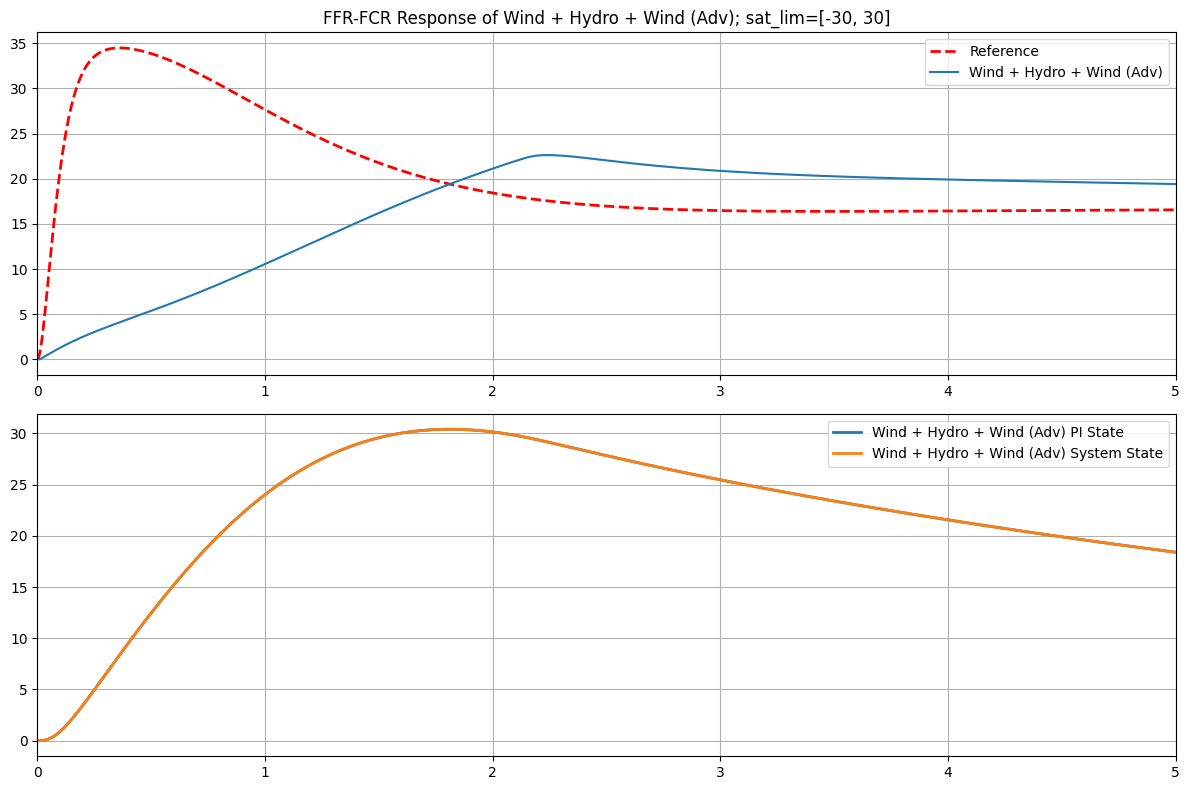

C:\Users\carlv\AppData\Roaming\Python\Python311\site-packages\control\nlsys.py:1197: UserWarning: Unused output(s) in InterconnectedSystem: (6, 0) : sys[474].e
  warn(msg)


Metrics for BESS + Hydro + Wind (Adv):
Steady-state error: 0.1455
Settling time (2%): 0.09 seconds
Overshoot: 103.82%


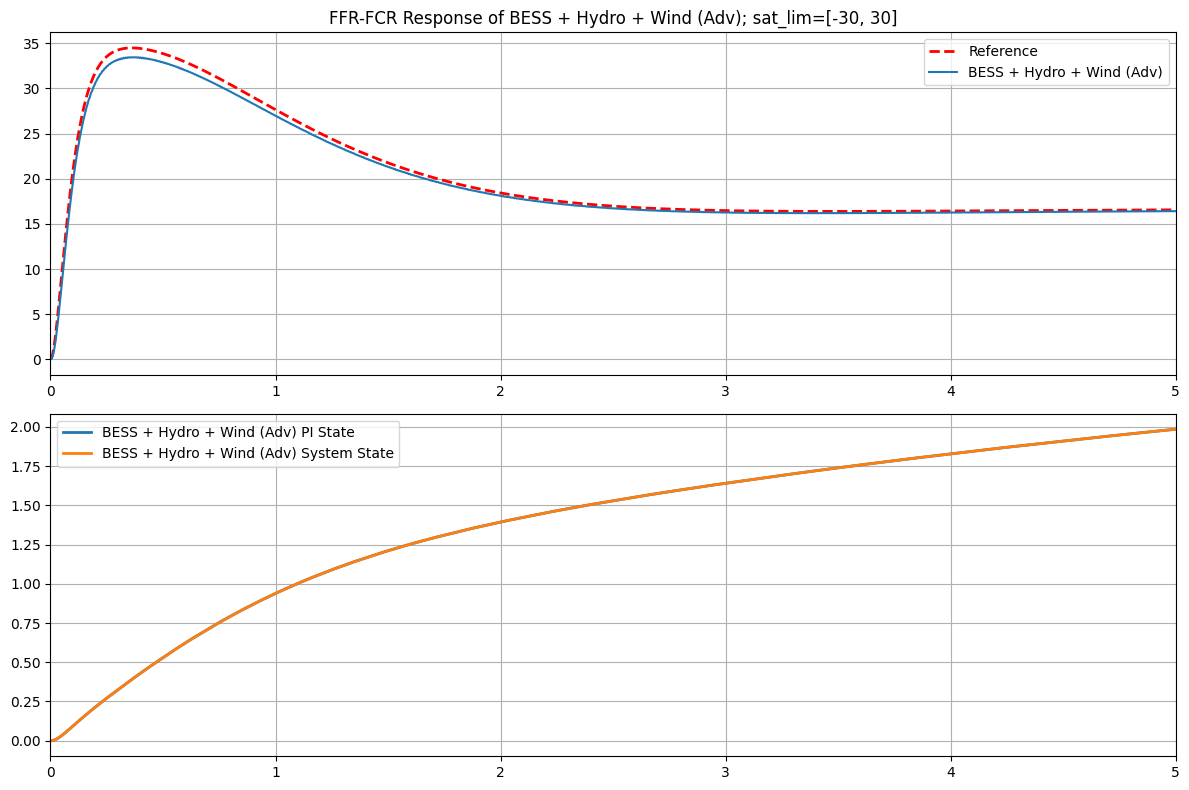

In [124]:
# aggregate 3 units
for subset in itertools.combinations(names, 3):
    name1, name2, name3 = subset
    G1, G2, G3 = Gs[name1], Gs[name2], Gs[name3]
    # rename for new closed loop
    G1.output_labels = ['y1']
    G1.name = name1
    G2.output_labels = ['y2']
    G2.name = name2
    G3.output_labels = ['y3']
    G3.name = name3
    y_total = ct.summing_junction(['y1', 'y2', 'y3'], 'y')  # create new total output
    error = ct.summing_junction(['yref', '-y'], 'e')  # error signal
    PI1, PI2, PI3 = PIs[name1], PIs[name2], PIs[name3]  # get PI controller
    PI1.output_labels = ['u1']
    PI1.name = f'PI_{name1}'
    PI2.output_labels = ['u2']
    PI2.name = f'PI_{name2}'
    PI3.output_labels = ['u3']
    PI3.name = f'PI_{name3}'
    G1.input_labels = ['u1']
    G2.input_labels = ['u2']
    G3.input_labels = ['u3']

    closed_loop_agg = ct.interconnect([PI1, PI2, G1, G2, G3, y_total, error], inputs=['yref'], outputs=['y'])
    name_agg = f'{name1} + {name2} + {name3}'

    check_control_system([closed_loop_agg], yffr_fcr_des, [name_agg], tlim=[0,5], title=f'FFR-FCR Response of {name_agg}; sat_lim={saturation_limits}')